In [1]:
import pyopencl as cl
import numpy as np
import pylab

import scipy
import PIL
import PIL.Image as im
from scipy import ndimage
from PIL import ImageEnhance
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
show = lambda img: plt.imshow(img.astype(int))
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# im = scipy.misc.imread('../test_large2.JPG',flatten=True)

def HE_serial(im_in):
    im = im_in.astype(int).copy()
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    cum_hist = np.cumsum(histogram)
    equal_hist = (cum_hist*256).astype(int)
    mapfunc = dict(zip(range(256), equal_hist))
    new_im = np.zeros_like(im)
    for i in range(height):
        for j in range(width):
            new_im[i,j] = mapfunc[im[i,j]]
    
    return new_im
    #plt.plot(range(0,256), cum_hist)

def histogram(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), histogram)
    plt.show()
    #return histogram

def hist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist)

def cumhist(im_input):
    im = im_input.astype(int)
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), np.cumsum(histogram))
    plt.show()
    
def cumhist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist.cumsum())
    

def HE_numpy(im_input,nbr_bins=256):
    im = im_input.astype(int)
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize

    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape)

def LHE_serial(im_input):
    gain = lambda s,A,S0: A-A/S0*s if A-A/S0*s>1 else 1
    im = im_input.astype(int).copy()
    height, width = im.shape
    im = np.pad(im, 4, mode='edge')
    new = np.zeros([height,width])
    for h in range(4,height+4):
        for w in range(4, width+4):
            window = im[h-4:h+5,w-4:w+5]
            old = im[h,w]
            M = np.mean(window)
            S = np.std(window)
            G = gain(S,20,10)
#             B = 0
#             if S*G-M>0:
#                 B = G*S-M
#             if S*G+M>255:
#                 B =(M+G*S)-255
            B=(128-M)*0.25
            N = (old-M)*G+B+M
            #if w==20:
                #print old,M,S,G,B,N
            if N>255:
                new[h-4,w-4]=255
            elif N<0:
                new[h-4,w-4]=0
            else:
                new[h-4,w-4]=N
    return new.astype(int)

def AHE_serial(im_input, windowwidth=21):
    im = im_input.astype(int).copy()
    height, width = im.shape
    new = np.zeros([height,width])
    d = windowwidth/2
    
    for h in range(height):
        for w in range(width):
            cur = im[h,w]
            window = im[h-d if h-d>-1 else 0:h+d+1 if h+d+1<height else height,
                        w-d if w-d>-1 else 0:w+d+1 if w+d+1<width else width]
            flat = [i for sub in window for i in sub]
            flat = flat + random.sample(flat+flat+flat+flat, windowwidth*windowwidth-len(flat))
            idx = np.sort(np.array(flat)).tolist().index(cur)
            
            new[h,w] = int(idx*1.0/windowwidth/windowwidth*256)
    return new

def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

In [3]:
def read_img_large_small(imgpath = '../test_large2.JPG'):
    # Read in images, im_orig is a large image, im is a small one.
    im_orig = scipy.misc.imread(imgpath,flatten=True)
    # Use a small image to test (by 12*12)
    im_small = np.array([im_orig[i][::12] for i in range(len(im_orig)) if i%12==0])
    return im_orig, im_small

In [47]:
def run_AHE_cl(img,clfile = 'HE.cl',windowsize=21):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()
    print 'The platforms detected are:'
    print '---------------------------'
    for platform in platforms:
        print platform.name, platform.vendor, 'version:', platform.version

    # List devices in each platform
    for platform in platforms:
        print 'The devices detected on platform', platform.name, 'are:'
        print '---------------------------'
        for device in platform.get_devices():
            print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
            print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
            print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
            print 'Maximum work group size', device.max_work_group_size
            print '---------------------------'

    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)
    print 'This context is associated with ', len(context.devices), 'devices'


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    AHE_out = np.zeros_like(img)

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, AHE_out.size * 4)

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])


    pad_size = np.int32(windowsize/2)
    # Set up a (N+8 x N+8) local memory buffer.
    # +2 for 1-pixel halo on all sides, 4 bytes for float.
    local_memory = cl.LocalMemory(4 * (local_size[0] + pad_size) * (local_size[1] + pad_size))
    # Each work group will have its own private buffer.
    buf_width = np.int32(local_size[0] + 2*pad_size)
    buf_height = np.int32(local_size[1] + 2*pad_size)
    halo = np.int32(pad_size)

    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])

    #max_iters = np.int32(1024)

    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)

    event = program.AHE_test(queue, global_size, local_size,
                           gpu_im, gpu_out, local_memory,
                           width, height,
                           buf_width, buf_height, halo,2*pad_size+1)

    cl.enqueue_copy(queue, AHE_out, gpu_out, is_blocking=True)

    seconds = (event.profile.end - event.profile.start) / 1e9

    gshow(AHE_out.astype(int))
    print "------------------------------------------"
    print "AHE serial on small image with size: ", img.shape
    print "Used time: ", seconds
    print "------------------------------------------"
    
    return AHE_out

In [48]:
def run_AHE_cl_no_print(img,clfile = 'HE.cl',windowsize=21):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()
    # List devices in each platform
    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    AHE_out = np.zeros_like(img)

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, AHE_out.size * 4)

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])


    pad_size = np.int32(windowsize/2)
    # Set up a (N+8 x N+8) local memory buffer.
    # +2 for 1-pixel halo on all sides, 4 bytes for float.
    local_memory = cl.LocalMemory(4 * (local_size[0] + pad_size) * (local_size[1] + pad_size))
    # Each work group will have its own private buffer.
    buf_width = np.int32(local_size[0] + 2*pad_size)
    buf_height = np.int32(local_size[1] + 2*pad_size)
    halo = np.int32(pad_size)

    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])

    #max_iters = np.int32(1024)

    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)

    event = program.AHE_test(queue, global_size, local_size,
                           gpu_im, gpu_out, local_memory,
                           width, height,
                           buf_width, buf_height, halo,2*pad_size+1)

    cl.enqueue_copy(queue, AHE_out, gpu_out, is_blocking=True)

    seconds = (event.profile.end - event.profile.start) / 1e9

    gshow(AHE_out.astype(int))
    
    return AHE_out,seconds

### Read in images, setting up environment

In [82]:
#################################
# Setting up environment
#################################
# List our platforms
platforms = cl.get_platforms()
print 'The platforms detected are:'
print '---------------------------'
for platform in platforms:
    print platform.name, platform.vendor, 'version:', platform.version

# List devices in each platform
for platform in platforms:
    print 'The devices detected on platform', platform.name, 'are:'
    print '---------------------------'
    for device in platform.get_devices():
        print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
        print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
        print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
        print 'Maximum work group size', device.max_work_group_size
        print '---------------------------'

# Create a context with all the devices
devices = platforms[0].get_devices()
context = cl.Context(devices)
print 'This context is associated with ', len(context.devices), 'devices'


# Create a queue for transferring data and launching computations.
# Turn on profiling to allow us to check event times.
queue = cl.CommandQueue(context, context.devices[0],
                        properties=cl.command_queue_properties.PROFILING_ENABLE)
print 'The queue is using the device:', queue.device.name

program = cl.Program(context, open('HE.cl').read()).build(options='')


# Read in images, im_orig is a large image, im is a small one.
im_orig = scipy.misc.imread('../test_large2.JPG',flatten=True)
# Use a small image to test (by 12*12)
im_small = np.array([im_orig[i][::12] for i in range(len(im_orig)) if i%12==0])


The platforms detected are:
---------------------------
Apple Apple version: OpenCL 1.2 (Sep 20 2014 22:01:02)
The devices detected on platform Apple are:
---------------------------
Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz [Type: CPU ]
Maximum clock Frequency: 2400 MHz
Maximum allocable memory size: 2147 MB
Maximum work group size 1024
---------------------------
Iris [Type: GPU ]
Maximum clock Frequency: 1100 MHz
Maximum allocable memory size: 402 MB
Maximum work group size 512
---------------------------
This context is associated with  2 devices
The queue is using the device: Iris


### 1) Serial HE, large

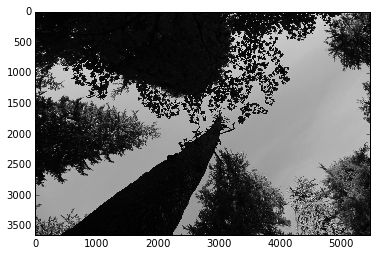

In [18]:
gshow(im_orig)

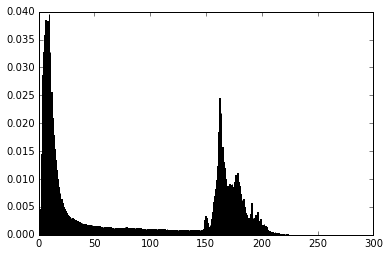

In [33]:
hist_np(im_orig)

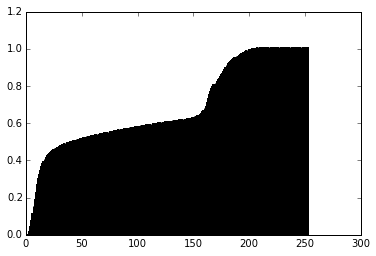

In [38]:
cumhist_np(im_orig)

In [16]:
%%time
im_HE_serial = HE_serial(im_orig)

CPU times: user 12.3 s, sys: 221 ms, total: 12.6 s
Wall time: 12.5 s


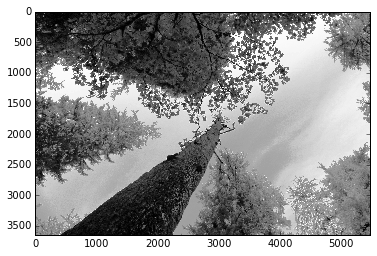

In [17]:
gshow(im_HE_serial)

CPU times: user 663 ms, sys: 99 ms, total: 762 ms
Wall time: 765 ms


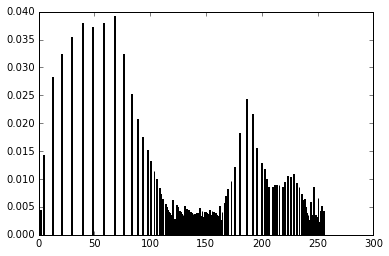

In [34]:
%%time
hist_np(im_HE_serial)

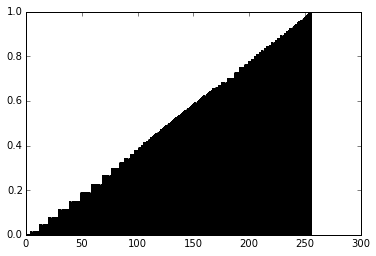

In [39]:
cumhist_np(im_HE_serial)

###2) HE_numpy, large

In [53]:
%%time
im_HE_numpy = HE_numpy(im_orig)

CPU times: user 878 ms, sys: 232 ms, total: 1.11 s
Wall time: 1.11 s


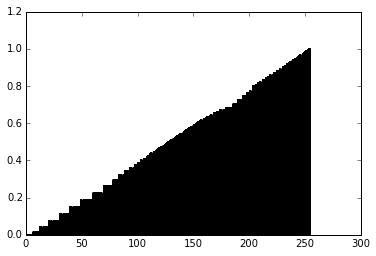

In [54]:
cumhist_np(im_HE_numpy)

### 3) LHE, small

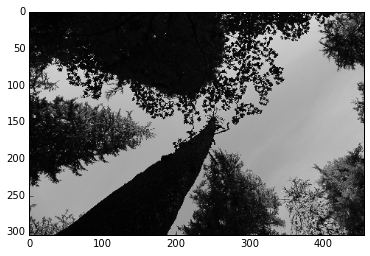

In [45]:
gshow(im_small)

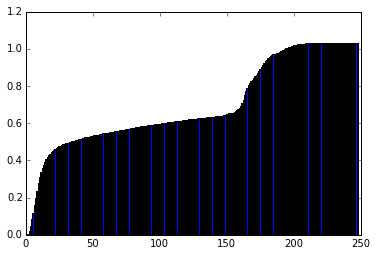

In [55]:
cumhist_np(im_small.astype(int))

In [56]:
%%time
im_LHE = LHE_serial(im_small)

CPU times: user 6.09 s, sys: 72.2 ms, total: 6.16 s
Wall time: 6.15 s


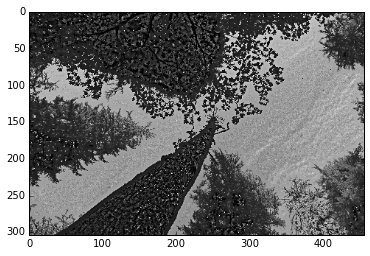

In [57]:
gshow(im_LHE)

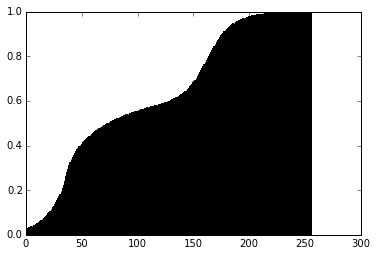

In [58]:
cumhist(im_LHE)

### 4) AHE_serial, small

In [59]:
%%time
im_AHE_serial = AHE_serial(im_small)

CPU times: user 23.4 s, sys: 90.4 ms, total: 23.5 s
Wall time: 23.6 s


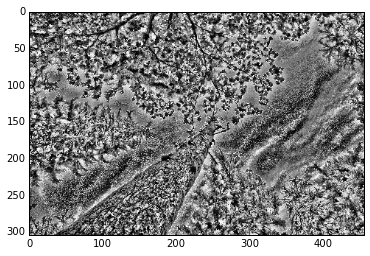

In [60]:
gshow(im_AHE_serial)

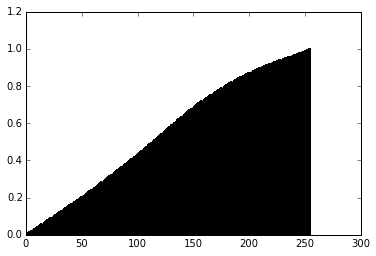

In [61]:
cumhist_np(im_AHE_serial)

### 5) AHE_cl, small

In [73]:
im_small=im_temp

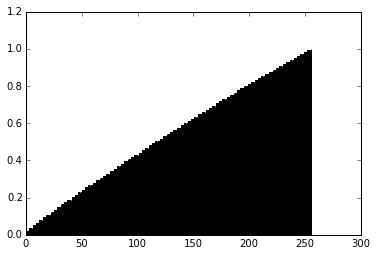

In [71]:
cumhist_np(AHE_out)

### 6) AHE_cl, large

(3648, 5472)
------------------------------------------
AHE serial on small image with size:  (3648, 5472)
Used time:  0.238114
------------------------------------------


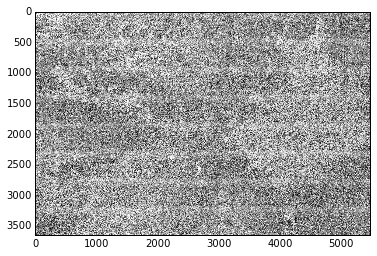

In [132]:
im_temp = im_small
im_small = im_orig
AHE_out = np.zeros_like(im_small)

gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, im_small.size * 4)
gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, AHE_out.size * 4)

local_size = (8, 8)  # 64 pixels per work group
global_size = tuple([round_up(g, l) for g, l in zip(im_small.shape[::-1], local_size)])


pad_size = np.int32(4)
# Set up a (N+8 x N+8) local memory buffer.
# +2 for 1-pixel halo on all sides, 4 bytes for float.
local_memory = cl.LocalMemory(4 * (local_size[0] + pad_size) * (local_size[1] + pad_size))
window_memory = cl.LocalMemory(4 * (2*pad_size+1) * (2*pad_size+1))
# Each work group will have its own private buffer.
buf_width = np.int32(local_size[0] + 2*pad_size)
buf_height = np.int32(local_size[1] + 2*pad_size)
halo = np.int32(pad_size/2)



print im_small.shape
width = np.int32(im_small.shape[1])
height = np.int32(im_small.shape[0])

#max_iters = np.int32(1024)

cl.enqueue_copy(queue, gpu_im, im_small, is_blocking=False)

event = program.AHE_test(queue, global_size, local_size,
                       gpu_im, gpu_out, local_memory,
                       width, height,
                       buf_width, buf_height, halo,2*pad_size+1)
cl.enqueue_copy(queue, AHE_out, gpu_out, is_blocking=True)

seconds = (event.profile.end - event.profile.start) / 1e9

gshow(AHE_out.astype(int))
print "------------------------------------------"
print "AHE serial on small image with size: ", im_small.shape
print "Used time: ", seconds
print "------------------------------------------"

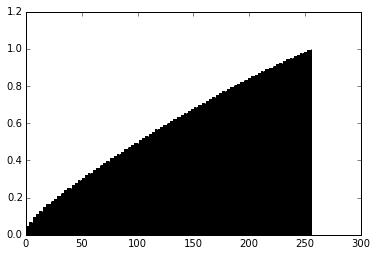

In [67]:
cumhist_np(AHE_out)

### tests

In [5]:
im_orig, im_small = read_img_large_small()

The platforms detected are:
---------------------------
Apple Apple version: OpenCL 1.2 (Sep 20 2014 22:01:02)
The devices detected on platform Apple are:
---------------------------
Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz [Type: CPU ]
Maximum clock Frequency: 2400 MHz
Maximum allocable memory size: 2147 MB
Maximum work group size 1024
---------------------------
Iris [Type: GPU ]
Maximum clock Frequency: 1100 MHz
Maximum allocable memory size: 402 MB
Maximum work group size 512
---------------------------
This context is associated with  2 devices
The queue is using the device: Iris
------------------------------------------
AHE serial on small image with size:  (304, 456)
Used time:  0.00862448
------------------------------------------


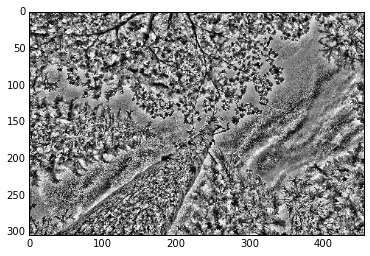

In [42]:
AHE_cl = run_AHE_cl(im_small,clfile = 'HE.cl')

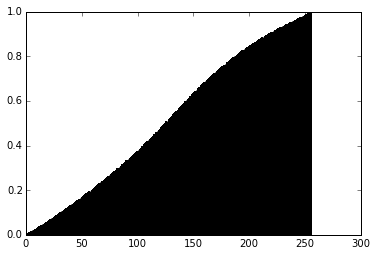

In [43]:
cumhist(AHE_cl)

In [26]:
im_small[227:231,227:231]

array([[ 155.14399719,  152.69200134,  150.69200134,  150.97999573],
       [ 152.05099487,  151.06199646,  150.69200134,  151.28999329],
       [ 151.06199646,  151.28999329,  152.28999329,  149.69200134],
       [ 149.69200134,  150.77400208,  152.06199646,  150.77400208]], dtype=float32)

In [123]:
%%time
im_AHE_serial_2 = AHE_serial(im_small, windowwidth=41)

CPU times: user 1min 16s, sys: 3.78 s, total: 1min 20s
Wall time: 1min 15s


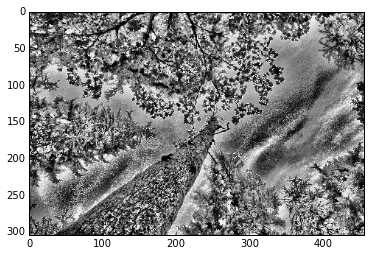

In [130]:
gshow(im_AHE_serial_2)

### Multi run

In [44]:
im_orig.shape

(3648, 5472)

In [48]:
import StringIO
import csv
s=''
for window in [5,9,13,17,21,25,29,33,37,41]:
    for shrinksize in [24, 12,8,6,3,2,1]:
        im_this = np.array([im_orig[i][::shrinksize] for i in range(len(im_orig)) if i%shrinksize==0])
        AHE_cl,t = run_AHE_cl_no_print(im_this,clfile = 'HE.cl',windowsize=window)
        print window,'\t',shrinksize,'\t',im_orig.size/shrinksize/shrinksize,'\t',t

5 	24 	34656 	0.00026008
5 	12 	138624 	0.00093744
5 	8 	311904 	0.002068
5 	6 	554496 	0.00363944
5 	3 	2217984 	0.01443496
5 	2 	4990464 	0.03306936
5 	1 	19961856 	0.11952968
9 	24 	34656 	0.00054144
9 	12 	138624 	0.00201744
9 	8 	311904 	0.00453216
9 	6 	554496 	0.00796752
9 	3 	2217984 	0.03232856
9 	2 	4990464 	0.07038936
9 	1 	19961856 	0.22867224
13 	24 	34656 	0.00076232
13 	12 	138624 	0.00286696
13 	8 	311904 	0.00693024
13 	6 	554496 	0.01218976
13 	3 	2217984 	0.05613384
13 	2 	4990464 	0.11943624
13 	1 	19961856 	0.3781124
17 	24 	34656 	0.0012168
17 	12 	138624 	0.00492976
17 	8 	311904 	0.01142864
17 	6 	554496 	0.02109264
17 	3 	2217984 	0.08768248
17 	2 	4990464 	0.1653048
17 	1 	19961856 	0.53967328
21 	24 	34656 	0.00178528
21 	12 	138624 	0.00729976
21 	8 	311904 	0.01768184
21 	6 	554496 	0.02891672
21 	3 	2217984 	0.10710856
21 	2 	4990464 	0.21105128
21 	1 	19961856 	0.66247408
25 	24 	34656 	0.0017248
25 	12 	138624 	0.00654128
25 	8 	311904 	0.01548296
25 	6 

KeyboardInterrupt: 